# Comparaison of dimentionality reduction algorithm and tradeoff calculation

In this notebook I will present my methodology to compare different algorithm according to a goal.


**Import of the libraries**

In [7]:
import pandas as pd
import os
import time
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

#Import de l'encodeur
from sklearn.preprocessing import OrdinalEncoder

#Import des differents librairies
import matplotlib.pyplot as plt
import numpy as np
import logging
import codecarbon
import pynvml
#from codecarbon.core.gpu import GPU, GPUDevice, AllGPUDevices
print("Libraries imported.")

Libraries imported.


**Creation of the logger to control the consumation output format**

In [3]:
class LoggerOutput:
    def __init__(self, logger, level=logging.INFO):
        self.logger = logger
        self.level = level

    def out(self, data):
        self.logger.log(self.level, data)


def create_tracker(name):
    log_name = f"carbon_{name}"
    _logger = logging.getLogger(log_name)

    _channel = logging.FileHandler(log_name + '.log')
    _logger.addHandler(_channel)

    _logger.setLevel(logging.INFO)

    my_logger = LoggerOutput(_logger, logging.INFO)
    os.makedirs(name, exist_ok=True)
    try:
        tracker = codecarbon.EmissionsTracker(output_dir=f'./{name}', save_to_logger=True, logging_logger=my_logger)
    except pynvml.NVMLError_NotSupported:
        print(f"Energy consumption tracking not supported for GPU. Creating tracker without GPU tracking for {name}.")
        tracker = codecarbon.EmissionsTracker(output_dir=f'./{name}', save_to_logger=True, logging_logger=my_logger, tracking_mode='cpu')
    
    return tracker


**Creation and preprocessing of the data used for the example**

In [ ]:
directory_path = './data/cubems-smart-building-energy-and-iaq-data'  # Adjust the path as needed
files = os.listdir(directory_path)

smart_building_data = []
for file in files:
    df = pd.read_csv(os.path.join(directory_path, file))
    smart_building_data.append(df)


common_cols = set.intersection(*[set(df.columns) for df in smart_building_data])
data = pd.concat([df[df.columns.intersection(common_cols)] for df in smart_building_data], ignore_index=True)

print("Fin de la concatenation des datasets")


**Encodage des data**

In [ ]:
print("Encodage des dates")
enc = OrdinalEncoder()
data[['Date']] = enc.fit_transform(data[['Date']])
data.fillna(0, inplace=True)


print("Dataset has a shape of ", data.shape[0], " rows and ", data.shape[1], " columns")


**Creation of 3 datasets from the data. One little, one medium and one big**

In [ ]:
target_sizes = {'little': 100000, 'medium': 1000000, 'big': 10000000}


def expand_data(df, target_size):
    repeats = (target_size // len(df)) + 1
    expanded_df = pd.concat([df] * repeats, ignore_index=True)
    return expanded_df.head(target_size)


data_little = expand_data(data, target_sizes['little'])
data_medium = expand_data(data, target_sizes['medium'])
data_big = expand_data(data, target_sizes['big'])


print("Fin de la generation des datasets")
print("Little dataset has a shape of ", data_little.shape[0], " rows and ", data_little.shape[1], " columns")
print("Medium dataset has a shape of ", data_medium.shape[0], " rows and ", data_medium.shape[1], " columns")
print("Big dataset has a shape of ", data_big.shape[0], " rows and ", data_big.shape[1], " columns")

# Experiment

In [28]:
def collect_results(algo_name, i, emission_little, time_little, emission_medium, time_medium, emission_big, time_big):
    return pd.DataFrame([{
        "iteration": i,
        f"little_data_energy": emission_little,
        f"little_data_time": time_little,
        f"medium_data_energy": emission_medium,
        f"medium_data_time": time_medium,
        f"big_data_energy": emission_big,
        f"big_data_time": time_big
    }])

columns = [
    "iteration",
    "little_data_energy", "little_data_time",
    "medium_data_energy", "medium_data_time",
    "big_data_energy", "big_data_time"
]
df_pca = pd.DataFrame(columns=columns)
df_tsne = pd.DataFrame(columns=columns)
df_rp = pd.DataFrame(columns=columns)
df_mds = pd.DataFrame(columns=columns)



**PCA EXPERIMENT**

In [ ]:
tracker_pca_little = create_tracker("pca_little")
tracker_pca_medium = create_tracker("pca_medium")
tracker_pca_big = create_tracker("pca_big")

In [ ]:
pca = PCA(n_components=2)
# for i in range(50):


tracker_pca_little.start()
start_time_little = time.time()
pca.fit_transform(data_little)
emission_pca_little = tracker_pca_little.stop()
time_final_little = time.time() - start_time_little


tracker_pca_medium.start()
start_time_medium = time.time()
pca.fit_transform(data_medium)
emission_pca_medium = tracker_pca_medium.stop()
time_final_medium = time.time() - start_time_medium

tracker_pca_big.start()
start_time_big = time.time()
pca.fit_transform(data_big)
emission_pca_big = tracker_pca_big.stop()
time_final_big = time.time() - start_time_big

df_pca = pd.concat([df_pca, collect_results('pca', i, emission_pca_little, time_final_little, emission_pca_medium, time_final_medium, emission_pca_big, time_final_big)], ignore_index=True)


df_pca.to_csv("pca_results.csv", index=False)


**RP EXPERIMENT**

In [ ]:
tracker_rp_little = create_tracker("rp_little")
tracker_rp_medium = create_tracker("rp_medium")
tracker_rp_big = create_tracker("rp_big")

In [ ]:
rp = GaussianRandomProjection(n_components=2)
# for i in range(50):

tracker_rp_little.start()
start_time_little = time.time()
rp.fit_transform(data_little)
emission_rp_little = tracker_rp_little.stop()
time_final_little = time.time() - start_time_little

tracker_rp_medium.start()
start_time_medium = time.time()
rp.fit_transform(data_medium)
emission_rp_medium = tracker_rp_medium.stop()
time_final_medium = time.time() - start_time_medium

tracker_rp_big.start()
start_time_big = time.time()
rp.fit_transform(data_big)
emission_rp_big = tracker_rp_big.stop()
time_final_big = time.time() - start_time_big

df_rp = pd.concat([df_rp, collect_results('rp', i, emission_rp_little, time_final_little, emission_rp_medium, time_final_medium, emission_rp_big, time_final_big)], ignore_index=True)
df_rp.to_csv("rp_results.csv", index=False)



**TSNE EXPERIMENT**

In [5]:
def split_and_evaluate_mds(mds,df, chunk_size=100, n_components=2):
    # List to store MDS results
    mds_results = []
    
    # Calculate the number of chunks
    num_chunks = (len(df) + chunk_size - 1) // chunk_size
    
    # Loop through each chunk
    for i in range(num_chunks):
        # Get the chunk
        chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size]
        
        # Check if the chunk is not empty
        if chunk.empty:
            continue
        
        # Perform MDS on the chunk
        mds.fit_transform(chunk)
        
        # Store the results
        
    
    return 1

In [ ]:
tracker_tsne_little = create_tracker("tsne_little")
tracker_tsne_medium = create_tracker("tsne_medium")
tracker_tsne_big = create_tracker("tsne_big")

In [ ]:
tsne = TSNE(n_components=2)


tracker_tsne_little.start()
start_time_little = time.time()
split_and_evaluate_mds(tsne,data_little)
emission_tsne_little = tracker_tsne_little.stop()
time_final_little = time.time() - start_time_little

tracker_tsne_medium.start()
start_time_medium = time.time()
split_and_evaluate_mds(tsne,data_medium)
emission_tsne_medium = tracker_tsne_medium.stop()
time_final_medium = time.time() - start_time_medium

tracker_tsne_big.start()
start_time_big = time.time()
split_and_evaluate_mds(tsne,data_big)
emission_tsne_big = tracker_tsne_big.stop()
time_final_big = time.time() - start_time_big

df_tsne = pd.concat([df_tsne, collect_results('tsne', i, emission_tsne_little, time_final_little, emission_tsne_medium, time_final_medium, emission_tsne_big, time_final_big)], ignore_index=True)
df_tsne.to_csv("tsne_results.csv", index=False)


**MDS EXPERIMENT**

In [ ]:
tracker_mds_little = create_tracker("mds_little")
tracker_mds_medium = create_tracker("mds_medium")
tracker_mds_big = create_tracker("mds_big")

In [ ]:

mds = MDS(n_components=2)
print("debut")
print('little')
tracker_mds_little.start()
start_time_little = time.time()
split_and_evaluate_mds(mds, data_little)
emission_mds_little = tracker_mds_little.stop()
time_final_little = time.time() - start_time_little

print('medium')
tracker_mds_medium.start()
start_time_medium = time.time()
split_and_evaluate_mds(mds, data_medium)
emission_mds_medium = tracker_mds_medium.stop()
time_final_medium = time.time() - start_time_medium

print('big')
tracker_mds_medium.start()
start_time_big = time.time()
split_and_evaluate_mds(mds, data_big)
emission_mds_big = tracker_mds_medium.stop()
time_final_big = time.time() - start_time_big

df_mds = pd.concat([df_mds, collect_results('mds', 0, emission_mds_little, time_final_little, emission_mds_medium, time_final_medium, emission_mds_big, time_final_big)], ignore_index=True)

df_mds.to_csv("mds_results.csv", index=False)


**Online PCA**

In [8]:
def ghapca_C(Q, x, y, gamma):
    """
    Update the matrix Q based on vectors x, y, and gamma.
    
    Parameters:
    Q : numpy.ndarray
        The matrix to be updated.
    x : numpy.ndarray
        The input vector.
    y : numpy.ndarray
        The projected vector.
    gamma : numpy.ndarray
        The learning rate vector.
    
    Returns:
    numpy.ndarray
        The updated matrix Q.
    """
    n, k = Q.shape
    
    # Update Q based on x, y, and gamma
    for i in range(k):
        for j in range(n):
            Q[j, i] += gamma[i] * (x[j] - Q[j, i] * y[i])
    
    return Q

def ghapca(lambda_values, U, x, gamma, q=None, center=None, sort=True):
    """
    Perform online PCA update.
    
    Parameters:
    lambda_values : numpy.ndarray or None
        The eigenvalues.
    U : numpy.ndarray
        The eigenvectors.
    x : numpy.ndarray
        The new data point.
    gamma : float or numpy.ndarray
        The learning rate.
    q : int or None
        The number of principal components to keep.
    center : numpy.ndarray or None
        The center to subtract from x.
    sort : bool
        Whether to sort the eigenvalues and eigenvectors.
    
    Returns:
    dict
        A dictionary with keys 'values' and 'vectors' for eigenvalues and eigenvectors.
    """
    d = U.shape[0]
    k = U.shape[1]
    
    if len(x) != d:
        raise ValueError("Length of x must be equal to the number of rows in U.")
    
    if lambda_values is not None:
        if len(lambda_values) != k:
            raise ValueError("Length of lambda must be equal to the number of columns in U.")
    
    if center is not None:
        x = x - center
    
    gamma = np.resize(gamma, k)
    
    if not isinstance(U, np.ndarray):
        U = np.array(U)
    
    y = np.dot(U.T, x)
    
    U = ghapca_C(U, x, y, gamma)
    
    if lambda_values is not None:
        lambda_values = (1 - gamma) * lambda_values + gamma * y ** 2
        if sort:
            ix = np.argsort(-lambda_values)  # Sorting in decreasing order
            if not np.array_equal(ix, np.arange(k)):
                lambda_values = lambda_values[ix]
                U = U[:, ix]
        if q is not None and q < k:
            lambda_values = lambda_values[:q]
    else:
        lambda_values = None
    
    if q is not None and q < k:
        U = U[:, :q]
    
    return {'values': lambda_values, 'vectors': U}


**Example of the usage of gha-pca**

In [ ]:
np.random.seed(123)

# Generate some synthetic multivariate data for testing
n = 100  # Number of observations
p = 5    # Number of variables
data = np.random.randn(n, p)
print(data)
# Initialize parameters for the GHA algorithm
q = 2  # Number of principal components to find
gamma = np.full(q, 1 / n)  # Learning rate (gain parameter)

# Initialize eigenvalues and eigenvectors
lambda_values = np.zeros(q)  # Initial eigenvalues
U = np.random.randn(p, q)  # Initial eigenvectors (random initialization)
U = U / np.sqrt(np.sum(U**2, axis=0))  # Normalize eigenvectors

# Centering vector (mean of each column)
center = np.mean(data, axis=0)

# Apply the GHA algorithm iteratively to each data point
for i in range(n):
    x = data[i, :]
    gha_result = ghapca(lambda_values, U, x, gamma, q, center, sort=True)
    lambda_values = gha_result['values']
    U = gha_result['vectors']

# Print the results
print("Updated Eigenvalues:")
print(lambda_values)

print("Updated Eigenvectors:")
print(U)

# Project data onto the new principal components
scores = np.dot(data, U)

# Plot the first two principal components
plt.scatter(scores[:, 0], scores[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GHA - First Two Principal Components")
plt.show()

# Plot of the results

**Read the time and energy consumption**

In [4]:
def read_algo(algo_name):
    path = './'
    big_emission = pd.read_csv(path + f'{algo_name}_big/emissions.csv')
    medium_emissions = pd.read_csv(path + f'{algo_name}_medium/emissions.csv')
    little_emissions = pd.read_csv(path + f'{algo_name}_little/emissions.csv')

    return big_emission, medium_emissions, little_emissions

In [5]:

pca_big, pca_medium, pca_little = read_algo('pca')
rp_big, rp_medium, rp_little = read_algo('rp')
tsne_big, tsne_medium, tsne_little = read_algo('tsne')
mds_big, mds_medium, mds_little = read_algo('mds')

pca_big_emissions, pca_medium_emissions, pca_little_emissions = pca_big['emissions'], pca_medium['emissions'], pca_little['emissions']
rp_big_emissions, rp_medium_emissions, rp_little_emissions = rp_big['emissions'], rp_medium['emissions'], rp_little['emissions']
tsne_big_emissions, tsne_medium_emissions, tsne_little_emissions = tsne_big['emissions'], tsne_medium['emissions'], tsne_little['emissions']
mds_big_emissions, mds_medium_emissions, mds_little_emissions = mds_big['emissions'], mds_medium['emissions'], mds_little['emissions']

pca_big_time, pca_medium_time, pca_little_time = pca_big['duration'], pca_medium['duration'], pca_little['duration']
rp_big_time, rp_medium_time, rp_little_time = rp_big['duration'], rp_medium['duration'], rp_little['duration']
tsne_big_time, tsne_medium_time, tsne_little_time = tsne_big['duration'], tsne_medium['duration'], tsne_little['duration']
mds_big_time, mds_medium_time, mds_little_time = mds_big['duration'], mds_medium['duration'], mds_little['duration']

print("Data Loaded.")

Data Loaded.


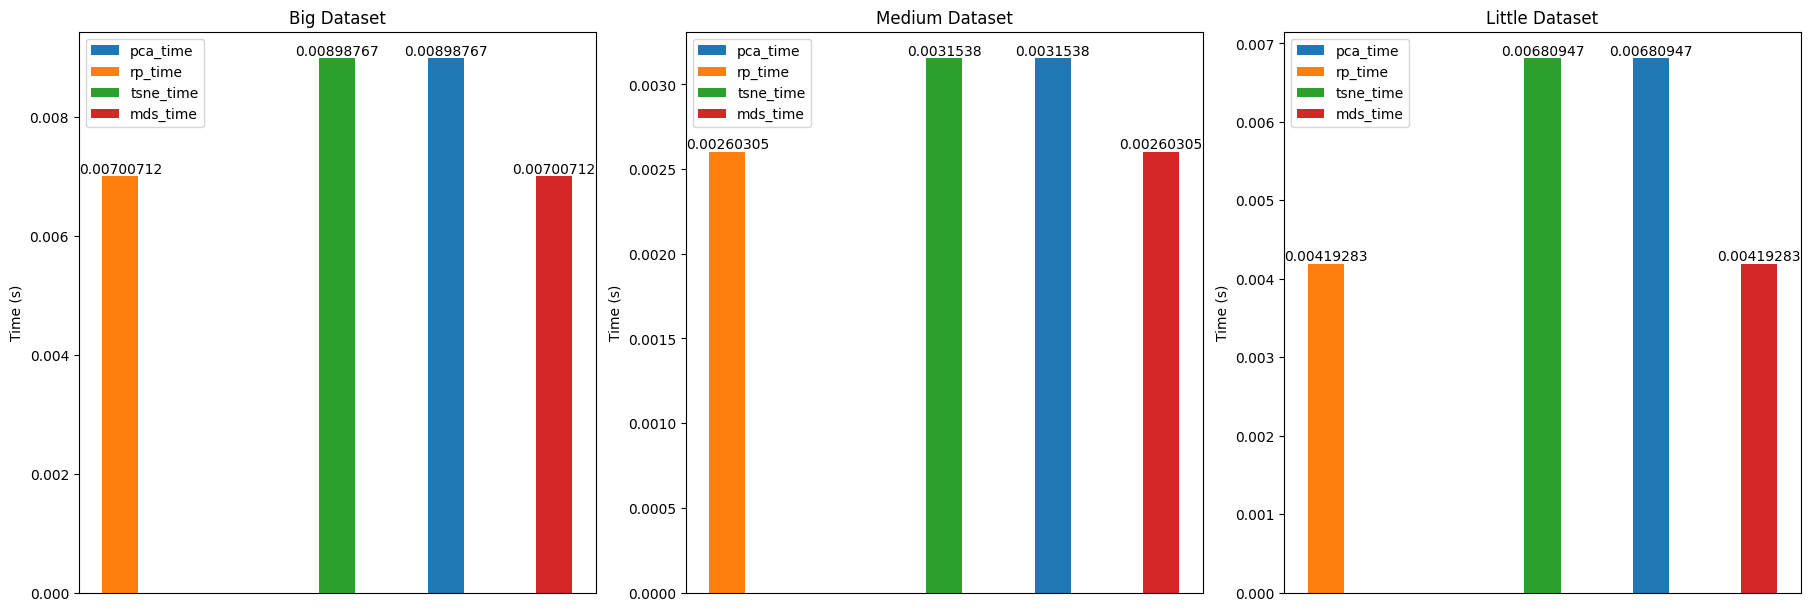

In [10]:
species = ("big", "medium", "little")

data_plot = {
    'pca_time': [pca_big_time[0], pca_medium_time[0], pca_little_time[0]],
    'rp_time': [rp_big_time[0], rp_medium_time[0], rp_little_time[0]],
    'tsne_time': [tsne_big_time[0], tsne_medium_time[0], tsne_little_time[0]],
    'mds_time': [mds_big_time[0], mds_medium_time[0], mds_little_time[0]]
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars

# Create subplots for each dataset size
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout='constrained')

dataset_sizes = ['Big Dataset', 'Medium Dataset', 'Little Dataset']

for idx, ax in enumerate(axs):
    for i, (attribute, measurement) in enumerate(data_plot.items()):
        rects = ax.bar(x[i-1] + i*width, measurement[idx], width, label=attribute)
        ax.bar_label(rects)
    
    ax.set_ylabel('Time (s)')
    ax.set_title(f'{dataset_sizes[idx]}')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.legend(loc='upper left')

plt.show()

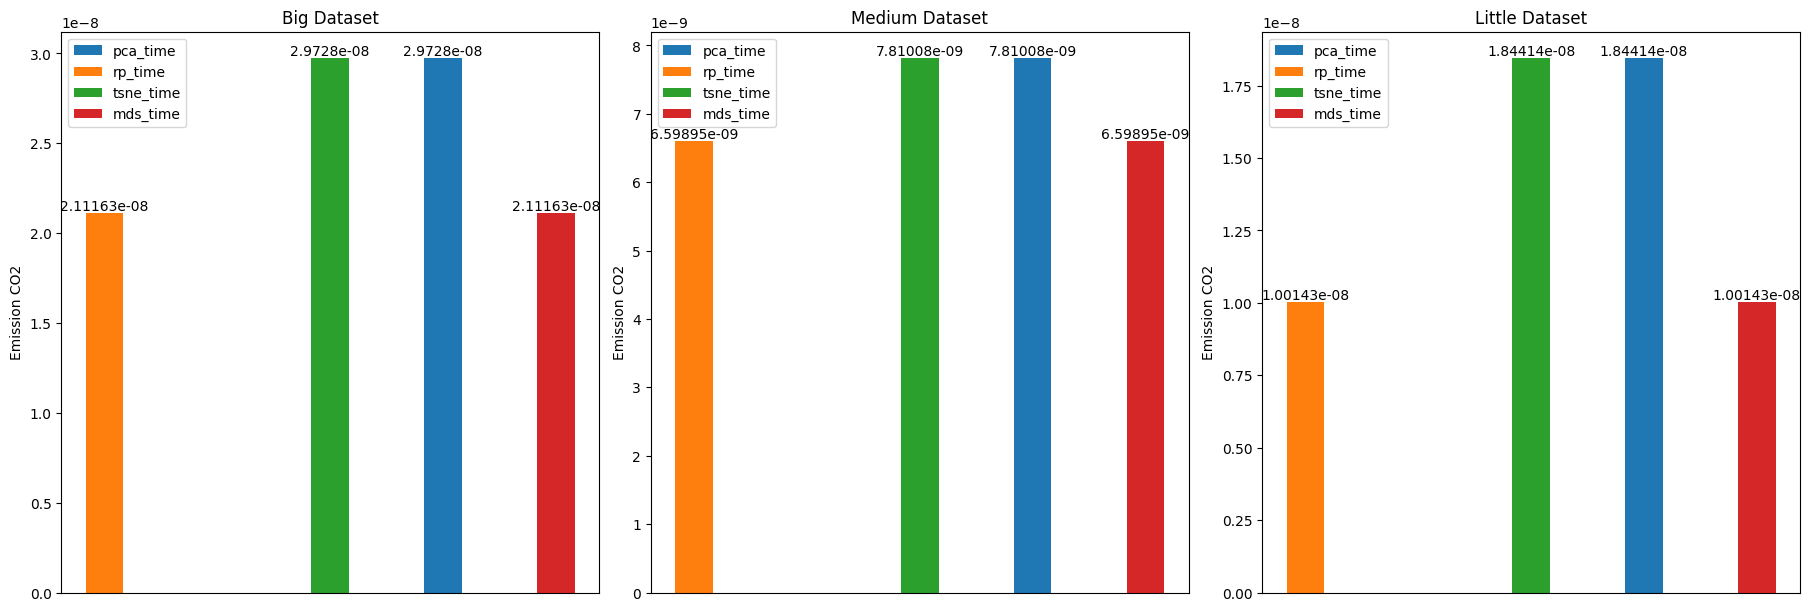

In [12]:
species = ("big", "medium", "little")

data_plot = {
    'pca_time': [pca_big_emissions[0], pca_medium_emissions[0], pca_little_emissions[0]],
    'rp_time': [rp_big_emissions[0], rp_medium_emissions[0], rp_little_emissions[0]],
    'tsne_time': [tsne_big_emissions[0], tsne_medium_emissions[0], tsne_little_emissions[0]],
    'mds_time': [mds_big_emissions[0], mds_medium_emissions[0], mds_little_emissions[0]]
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars

# Create subplots for each dataset size
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout='constrained')

dataset_sizes = ['Big Dataset', 'Medium Dataset', 'Little Dataset']

for idx, ax in enumerate(axs):
    for i, (attribute, measurement) in enumerate(data_plot.items()):
        rects = ax.bar(x[i-1] + i*width, measurement[idx], width, label=attribute)
        ax.bar_label(rects)
    
    ax.set_ylabel('Emission CO2')
    ax.set_title(f'{dataset_sizes[idx]}')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.legend(loc='upper left')

plt.show()

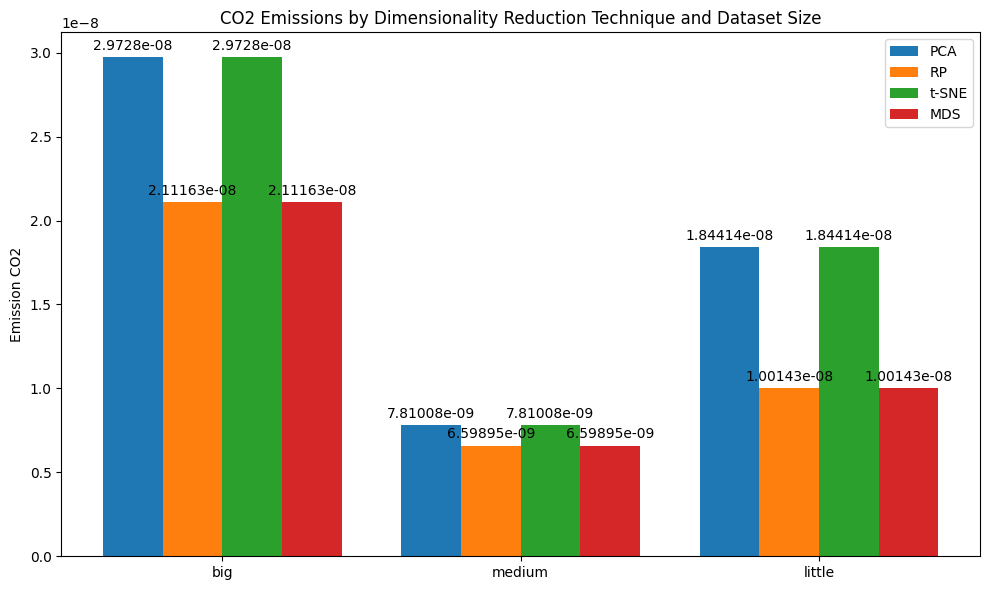

In [13]:
import numpy as np
import matplotlib.pyplot as plt

species = ["big", "medium", "little"]

data_plot = {
    'pca_time': [pca_big_emissions[0], pca_medium_emissions[0], pca_little_emissions[0]],
    'rp_time': [rp_big_emissions[0], rp_medium_emissions[0], rp_little_emissions[0]],
    'tsne_time': [tsne_big_emissions[0], tsne_medium_emissions[0], tsne_little_emissions[0]],
    'mds_time': [mds_big_emissions[0], mds_medium_emissions[0], mds_little_emissions[0]]
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
rects1 = ax.bar(x - 1.5*width, data_plot['pca_time'], width, label='PCA')
rects2 = ax.bar(x - 0.5*width, data_plot['rp_time'], width, label='RP')
rects3 = ax.bar(x + 0.5*width, data_plot['tsne_time'], width, label='t-SNE')
rects4 = ax.bar(x + 1.5*width, data_plot['mds_time'], width, label='MDS')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Emission CO2')
ax.set_title('CO2 Emissions by Dimensionality Reduction Technique and Dataset Size')
ax.set_xticks(x)
ax.set_xticklabels(species)
ax.legend()

# Add labels to the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()
